In [1]:
#Dev
import collections
import math
import os
import errno
import random
import zipfile

import numpy as np
from six.moves import urllib
from six.moves import xrange 
import tensorflow as tf
import pandas as pd
# this part needed for mac
# import pymysql
# pymysql.install_as_MySQLdb()
############################
import seaborn as sns
from mysql.connector import MySQLConnection, Error
from XML2MySQL import connect
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
%matplotlib inline

class MySQL2PandasDF:
    '''
    Takes the string connection elements of a MySQL database as input
    Class should only be initialized once - container holds database connection upon init
        All database tables are stored as Pandas DataFrames when returning class instance
        Allows a user to query MySQL normally and return a dataframe of the search results
        Stores user query history and optionally allows user to give each query a unique identifier
    '''
    def __init__(self,host,db,user,password):
        
        self.host = host
        connection_string = 'mysql+mysqldb://'+user+':'+password+'@'+host+'/'+db
        self.query_connection = create_engine(connection_string)
        try:
            self.db_connection = MySQLConnection(
                                        host = host,
                                        database = db,
                                        user = user,
                                        password = password)
            if self.db_connection.is_connected():
                print('Connection to MySQL database ' + db + ' successful.')
        except Error:
            print('Error connecting to database ' + db)
            print(Error)
            
        self.source = dict()
        self.history = dict()
        self.plots = dict()
    
    def db2df(self, db_connection=None):
        """
        Sets self.source, an entire database as a dictionary of pandas DataFrames accessible by table name keys
        Optionally takes a MySQLConnection object as input with the db_connection parameter
        :params: (MySQLConnection object)
        :return: {Table: pd.DataFrame}
        """
        if db_connection is None:
            pass
        else:
            self.db_connection = db_connection
        cursor = self.db_connection.cursor()
        cursor.execute("SHOW TABLES")
        rows = cursor.fetchall()
        self.source = dict()
        for dummy_table_name in rows:
            self.source[dummy_table_name[0]] = pd.read_sql_table(dummy_table_name[0],self.query_connection)
        cursor.close()

    
    def query_mysql(self, query, title):
        """
        Query a MySQL database and return a pandas DataFrame
        Class tracks user history using a dictionary
        User must provide question title as it is the key for the DataFrame returned
        :params: MySQL query, title
        :return: {Query Title: pd.DataFrame}, DataFrame
        """
        if str(type(title)) != "<class 'str'>":
            title = input('Title must be be a string: ')
        else:
            df = pd.read_sql(query,self.query_connection)
            self.history[title] = df
        return df
            
    def plotdf(self, plot, title):
        """
        Plot a pd.series as a given plot title
        Class tracks plot history
        User must provide plot title as it is key for DataFrame returned
        :params: Seaborn or Matplotlibe object, plot title
        :return: {Plot Title: plot}, plot
        """
        if str(type(title)) != "<class 'str'>":
            title = input('Title must be be a string: ')
        else:
            self.plots[title] = plot
        return plot

# Init Session Object

In [2]:
session = MySQL2PandasDF(host = 'localhost', db = 'stackexchange_travel', user = 'root', password = 'F0xyrules30')

Connection to MySQL database stackexchange_travel successful.


## db2df method parses the entirety of a database to pandas dfs

In [3]:
session.db2df()

C:\Users\jeffe\Anaconda3\lib\site-packages\sqlalchemy\dialects\mysql\base.py:1546: Warning: (1287, "'@@tx_isolation' is deprecated and will be removed in a future release. Please use '@@transaction_isolation' instead")
  cursor.execute('SELECT @@tx_isolation')


Underlying structure is a dictionary with the following format:

{Table Name: df}

In [4]:
# tables in our dictionary

session.source.keys()

dict_keys(['badges', 'comments', 'posthistory', 'postlinks', 'posts', 'tags', 'users', 'votes'])

## Head of every table in database

In [5]:
session.source['badges'].head()

,index,class,Date,id,Name,TagBased,userId
0,0,3,2011-06-21 20:16:49,1,Autobiographer,False,2
1,1,3,2011-06-21 20:16:49,2,Autobiographer,False,3
2,2,3,2011-06-21 20:16:49,3,Autobiographer,False,4
3,3,3,2011-06-21 20:21:49,4,Autobiographer,False,6
4,4,3,2011-06-21 20:21:49,5,Autobiographer,False,8


In [6]:
session.source['comments'].head()

,index,CreationDate,Id,PostId,score,Text,UserDisplayName,userId
0,0,2011-06-21T20:25:14.257,1,1,0,To help with the cruise line question: Where a...,None,12.0
1,1,2011-06-21T20:27:35.300,2,1,0,"Toronto, Ontario. We can fly out of anywhere t...",None,9.0
2,2,2011-06-21T20:32:23.687,3,1,3,"""Best"" for what? Please read [this page](http...",None,20.0
3,3,2011-06-21T20:42:08.330,9,25,0,"Are you in the UK? If so, would be helpful to ...",None,30.0
4,4,2011-06-21T20:44:09.990,12,26,3,"Where are you starting from, and what sort of ...",None,26.0


In [7]:
session.source['posthistory'].head()

,index,Comment,CreationDate,Id,PostHistoryTypeId,PostID,RevisionGUID,Text,UserDisplayName,UserId
0,0,None,2011-06-21T20:19:34.730,1,2,1,1e04af17-3bdb-4263-aa46-97ee7fb1b0b6,My finance and myself are looking for a good C...,None,9.0
1,1,None,2011-06-21T20:19:34.730,2,1,1,1e04af17-3bdb-4263-aa46-97ee7fb1b0b6,What's the best Caribbean cruise for October,None,9.0
2,2,None,2011-06-21T20:19:34.730,3,3,1,1e04af17-3bdb-4263-aa46-97ee7fb1b0b6,<caribbean><cruising><vacations>,None,9.0
3,3,None,2011-06-21T20:22:33.760,4,2,2,58500a29-b9ed-4802-9934-c173ce362758,"This was one of our definition questions, but ...",None,13.0
4,4,None,2011-06-21T20:22:33.760,5,1,2,58500a29-b9ed-4802-9934-c173ce362758,How can I find a guide that will take me safel...,None,13.0


In [8]:
session.source['postlinks'].head()

,index,CreationDate,Id,LinkTypeId,PostId,RelatedPostId
0,0,2011-06-21 20:49:20,168,1,28,25
1,1,2011-06-21 22:55:01,1304,1,110,10
2,2,2011-06-22 11:58:40,2930,1,203,185
3,3,2011-06-22 12:32:01,2981,1,189,105
4,4,2011-06-22 20:56:21,3507,1,226,185


In [9]:
session.source['posts'].head()

,index,AcceptedAnswerId,AnswerCount,Body,ClosedDate,CommentCount,CommunityOwnedDate,CreationDate,FavoriteCount,Id,...,LastEditorDisplayName,LastEditorUserId,OwnerDisplayName,OwnerUserId,ParentId,PostTypeId,Score,Tags,Title,ViewCount
0,0,393,4,<p>My fiancée and I are looking for a good Car...,2013-02-25T23:52:47.953,4,NaT,2011-06-21T20:19:34.730,NaN,1,...,None,101.0,None,9.0,NaN,1,8,<caribbean><cruising><vacations>,What are some Caribbean cruises for October?,419.0
1,1,None,7,"<p>This was one of our definition questions, b...",None,4,NaT,2011-06-21T20:22:33.760,5.0,2,...,None,13.0,None,13.0,NaN,1,32,<guides><extreme-tourism><amazon-river><amazon...,How can I find a guide that will take me safel...,1399.0
2,2,None,None,<p>One way would be to go through an Adventure...,None,2,NaT,2011-06-21T20:24:28.080,NaN,3,...,None,NaN,None,9.0,2.0,2,12,None,None,NaN
3,3,None,1,<p>Singapore Airlines has an all-business clas...,None,1,NaT,2011-06-21T20:24:57.160,NaN,4,...,None,693.0,None,24.0,NaN,1,8,<loyalty-programs><routes><ewr><singapore-airl...,Does Singapore Airlines offer any reward seats...,243.0
4,4,770,5,<p>Another definition question that interested...,None,0,NaT,2011-06-21T20:25:56.787,2.0,5,...,None,101.0,None,13.0,NaN,1,14,<romania><transportation>,What is the easiest transportation to use thro...,395.0


In [10]:
session.source['tags'].head()

,index,Count,ExcerptPostId,Id,TagName,WikiPostId
0,0,104,2138.0,1,cruising,2137.0
1,1,43,357.0,2,caribbean,356.0
2,2,43,319.0,4,vacations,318.0
3,3,8,14548.0,6,amazon-river,14547.0
4,4,100,1792.0,8,romania,1791.0


In [11]:
session.source['users'].head()

,index,AboutMe,accountid,age,CreationDate,DisplayName,downvotes,Id,LastAccessDate,Location,ProfileImageUrl,reputation,upvotes,Views,WebsiteUrl
0,0,"<p>Hi, I'm not really a person.</p>\n\n<p>I'm ...",-1.0,NaN,2011-06-21T15:16:44.253,Community,12646,-1,2011-06-21T15:16:44.253,on the server farm,None,1,2472,0,http://meta.stackexchange.com/
1,1,<p>Developer on the Stack Overflow team. Find...,2.0,40.0,2011-06-21T20:10:03.720,Geoff Dalgas,0,2,2016-05-29T01:18:20.767,"Corvallis, OR",None,101,1,31,http://stackoverflow.com
2,2,"<p>I am the <a href=""http://stackoverflow.com/...",7598.0,32.0,2011-06-21T20:11:02.490,Nick Craver,0,3,2015-09-14T12:03:40.247,"Winston-Salem, NC",https://i.stack.imgur.com/nGCYr.jpg?s=128&g=1,101,1,14,https://nickcraver.com/blog/
3,3,"<p>co-founder of <a href=""https://airtable.com...",1998.0,31.0,2011-06-21T20:12:21.223,Emmett,0,4,2013-03-01T22:30:26.790,"San Francisco, CA",https://i.stack.imgur.com/d1oHX.jpg?s=128&g=1,101,1,10,http://minesweeperonline.com
4,4,"<p><a href=""http://blog.stackoverflow.com/2010...",29738.0,NaN,2011-06-21T20:15:31.410,Kevin Montrose,0,5,2017-02-07T02:24:34.733,"New York, NY, United States",None,101,1,11,http://kevinmontrose.com/


In [12]:
session.source['votes'].head()

,index,BountyAmount,CreationDate,Id,PostId,UserId,VoteTypeId
0,0,NaN,2011-06-21,1,1,NaN,2
1,1,NaN,2011-06-21,2,1,NaN,2
2,2,NaN,2011-06-21,3,2,NaN,2
3,3,NaN,2011-06-21,4,3,NaN,2
4,4,NaN,2011-06-21,5,5,13.0,5


# Data Exploration

### Now we can begin asking questions about our data

Using either MySQL syntax or the built in functionality/flexability of pandas DataFrames

For example, lets plot the post history by tag

In [13]:
q1 = 'Most Viewed posts by Tag category'

query1 = '   SELECT t.TagName, t.Count \
             FROM stackexchange_travel.tags t \
             ORDER BY t.Count DESC \
             LIMIT 25'

session.query_mysql(query1,q1)

,TagName,Count
0,visas,5271
1,usa,2858
2,air-travel,2830
3,uk,2114
4,schengen,2094
5,customs-and-immigration,1798
6,transit,1204
7,trains,1031
8,passports,954
9,indian-citizens,916


In [62]:
session.history[q1]['TagName'][0]

'visas'

# Find posts tagged to multiple items and plot post activity

In [73]:
def plot_post_activity_for_posts_with_multiple_tags(tags_search_term1, tags_search_term2):
    """
    This function returns a histogram of post activity for posts tagged with any two tags
    
    params:     tags_search_term1: str: first tag search term to find posts with
                tags_search_term2: str: second tag search term to find posts with
                
    return:     matplotlib.pyplot.hist of number of post reponses for given topic
    """
    if isinstance(tags_search_term1,str) and isinstance(tags_search_term2,str):
        # Extract html from body of posts
        session.source['posts']['Body_extract1'] = session.source['posts']["Body"].str.findall(r">(:?.+)<").str.join(' ')
        session.source['posts']['Body_links'] = session.source['posts']["Body_extract1"].str.findall(r">(:?.+)<").str.join('').str.findall(r'"(:?.+)"').str.join(' ')
        session.source['posts']['Tags_tags_removed'] = session.source['posts']['Tags'].str.findall(r"<(:?.+)>").str.join('').str.replace('>','').str.replace('<',' ')
        
        # Create search space to find search terms within
        # Groupby and stage data
        session.source['posts_'+tags_search_term1+'_tags'] = session.source['posts'][session.source['posts']['Tags_tags_removed'].str.contains(tags_search_term1,na=False)]
        session.source['posts_'+tags_search_term1+'_tags']['Search_Space'] = session.source['posts_'+tags_search_term1+'_tags']['Tags_tags_removed'].map(str) + ' ' + session.source['posts_'+tags_search_term1+'_tags']['Title']
        session.source['posts_'+tags_search_term1+'_tagged_'+tags_search_term2] = session.source['posts_'+tags_search_term1+'_tags'][session.source['posts_'+tags_search_term1+'_tags']['Search_Space'].str.lower().str.contains(tags_search_term2,na=False)]
        session.source['posts_'+tags_search_term1+'_tagged_'+tags_search_term2+'_Title_Body_Links'] = session.source['posts_'+tags_search_term1+'_tagged_'+tags_search_term2].sort_values('ViewCount', ascending=False)[['Id','Title', 'Body_extract1', 'Body_links']]
        session.source['comments_id_score_text'] = session.source['comments'][['PostId','score','Text']]
        session.source['posts_'+tags_search_term1+'_tagged_'+tags_search_term2+'_Title_Body_Links_comments_id_score_text'] = pd.merge(session.source['posts_'+tags_search_term1+'_tagged_'+tags_search_term2+'_Title_Body_Links'], session.source['comments_id_score_text'],left_on='Id', right_on='PostId')
        session.source['posts_'+tags_search_term1+'_tagged_'+tags_search_term2+'_Title_Body_Links_comments_id_score_text_qs_sorted_by_number_of_comments'] = session.source['posts_'+tags_search_term1+'_tagged_'+tags_search_term2+'_Title_Body_Links_comments_id_score_text'].groupby('Title').count().sort_values('Text', ascending=False)
        
        # Plot
        piccap = 'Frequency Distribution of Comments on Posts Tagged '+tags_search_term1+' and '+tags_search_term2
        session.plotdf(sns.distplot(session.source['posts_'+tags_search_term1+'_tagged_'+tags_search_term2+'_Title_Body_Links_comments_id_score_text_qs_sorted_by_number_of_comments']['Text']),piccap)
        plt.title('Histogram of Responses to Posts Tagged '+tags_search_term1+' and '+ tags_search_term2)
        plt.xlabel('Number of Responses')
        plt.ylabel('Frequency')
    else:
        input('Inputs must be strings. Press any key to exit program.')
        sys.exit()

C:\Users\jeffe\Anaconda3\lib\site-packages\ipykernel\__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


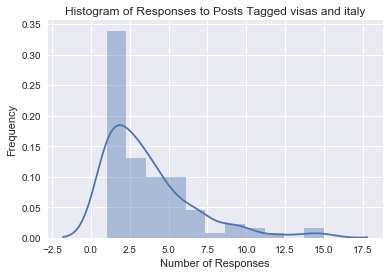

In [76]:
search_posts_multiple_tags('visas','italy')

C:\Users\jeffe\Anaconda3\lib\site-packages\ipykernel\__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


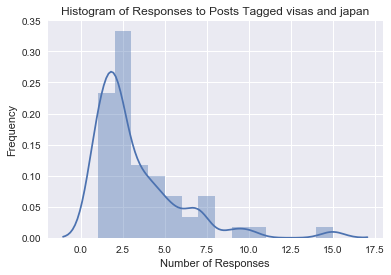

In [77]:
search_posts_multiple_tags('visas','japan')

C:\Users\jeffe\Anaconda3\lib\site-packages\ipykernel\__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


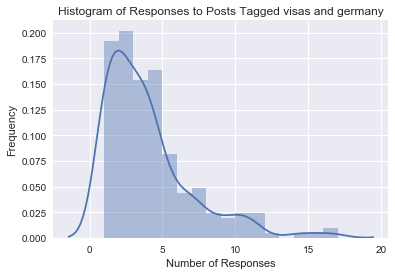

In [78]:
search_posts_multiple_tags('visas','germany')

C:\Users\jeffe\Anaconda3\lib\site-packages\ipykernel\__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


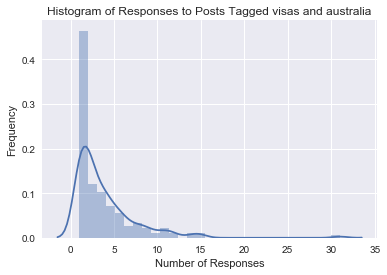

In [79]:
search_posts_multiple_tags('visas','australia')

C:\Users\jeffe\Anaconda3\lib\site-packages\ipykernel\__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


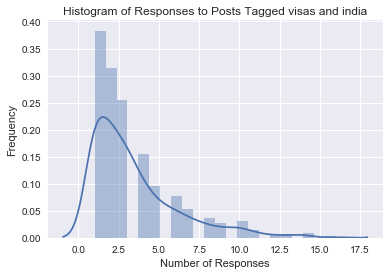

In [80]:
search_posts_multiple_tags('visas','india')

C:\Users\jeffe\Anaconda3\lib\site-packages\ipykernel\__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


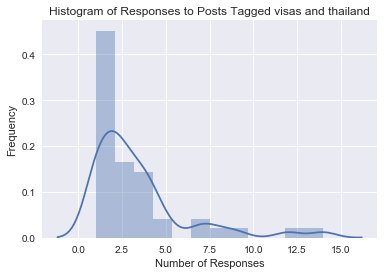

In [83]:
search_posts_multiple_tags('visas','thailand')

## Comparison of post activities

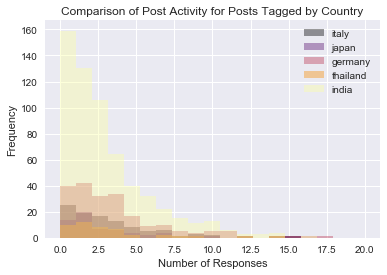

In [82]:
bins = np.linspace(0, 20, 20)
number = 5
cmap = plt.get_cmap('inferno')
colors = [cmap(i) for i in np.linspace(0, 1, number)]
for search_term, color in zip(['italy','japan','germany','thailand', 'india'], colors):
    plt.hist(session.source['posts_visa_tagged_'+search_term+'_Title_Body_Links_comments_id_score_text_qs_sorted_by_number_of_comments']['Text'], bins, alpha=0.4, label=search_term, color=color)
plt.xlabel('Number of Responses')
plt.ylabel('Frequency')
plt.legend(loc='upper right')
plt.title('Comparison of Post Activity for Posts Tagged by Country')

Posts tagged 'visas' and 'india' have the most post activity out of the 5 countries explored